In [1]:
import pandas as pd
import numpy as np
import GridMet as gm

In [2]:
strt = '1989-10-01'
nd = '2012-09-30'

In [3]:
niwot1 = pd.read_pickle('/RHESSys/ComoCreek_new/clim/niwot_snotel.pcl')[strt:nd]
c1_P1 = pd.read_pickle('/RHESSys/ComoCreek_new/clim/C1_chart_prec.pcl')[strt:nd]

#c1_P1.head(20)

In [4]:
for i in c1_P1.index:
    
    # skip entries that are only one day
    if (c1_P1.loc[i,'Qual_days'] == 1) or (np.isnan(c1_P1.loc[i,'Qual_days']) == True):
        continue
    else:
        days = c1_P1.loc[i,'Qual_days']
        td = pd.datetools.timedelta(days-1)
        strt2 = i-td
        c1_P1.loc[strt2:i,'P'] = c1_P1.loc[i,'P']/float(days)
        c1_P1.loc[strt2:i,'Qual_days'] = 1.
        c1_P1.loc[strt2:i,'flag'] = 'F'

c1_T1 = pd.read_pickle('/RHESSys/ComoCreek_new/clim/C1_chart_temp.pcl')[strt:nd]

## now do D1

d1_P1 = pd.read_pickle('/RHESSys/ComoCreek_new/clim/D1_prec.pcl')[strt:nd]

for i in d1_P1.index:
    
    # skip entries that are only one day
    if (d1_P1.loc[i,'Qual_days'] == 1) or (np.isnan(d1_P1.loc[i,'Qual_days']) == True):
        continue
    else:
        days = d1_P1.loc[i,'Qual_days']
        td = pd.datetools.timedelta(days-1)
        strt2 = i-td
        d1_P1.loc[strt2:i,'P'] = d1_P1.loc[i,'P']/float(days)
        d1_P1.loc[strt2:i,'Qual_days'] = 1.
        d1_P1.loc[strt2:i,'flag'] = 'F'

d1_T1 = pd.read_pickle('/RHESSys/ComoCreek_new/clim/D1_temp.pcl')[strt:nd]

## now tile the met data

In [16]:
reps = 15
nd = pd.datetime(2250,9,30)

In [17]:
# niwot
Tmax = np.tile(niwot1.ATmax.as_matrix(),reps)
Tmin = np.tile(niwot1.ATmin.as_matrix(),reps)
precip = np.tile(niwot1.precip.as_matrix(),reps)

td = pd.datetools.timedelta(len(Tmax))


index = pd.date_range(start=nd-td,periods=len(Tmax))

IndexError: index 0 is out of bounds for axis 0 with size 0

In [5]:
niwot = gm.makeGridMetStation('niwot_snotel',3020.,niwot1.index,niwot1.ATmax,niwot1.ATmin,niwot1.ATave,niwot1.precip)
c1 = gm.makeGridMetStation('c1',3018.,c1_T1.index,c1_T1.Tmax,c1_T1.Tmin,c1_T1.Tave,c1_P1.P)
d1 = gm.makeGridMetStation('d1',3743.,d1_T1.index,d1_T1.Tmax,d1_T1.Tmin,d1_T1.Tave,d1_P1.P)

In [6]:
lapse = gm.makeGridMetLapseRate('como',c1,d1,'m')

In [7]:
dem_path = '/RHESSys/ComoCreek_new/auxdata/como_gridclim_180m.tiff'
patch_path = '/RHESSys/ComoCreek_new/auxdata/gridmet_map.tiff'
frmt = 'asciiGrid'
out_path = '/RHESSys/ComoCreek_new/clim/'
prfx = 'como_grid'

In [8]:
gm.GridMet()

TypeError: GridMet() takes exactly 7 arguments (0 given)

In [9]:
niwot.index.max()

Timestamp('2013-12-31 00:00:00')

In [9]:
gm.GridMet(dem_path,patch_path,niwot,lapse,out_path,frmt,prfx)

[****************100%******************]  8401 of 8401 complete Saving asciiGrid files.
Done!


In [14]:
lapse.Tlapse['2012-12']

2012-12-31   -0.013971
Freq: M, Name: Tlapse, dtype: float64

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
%matplotlib inline

In [110]:
def doy(dt):
    import pandas as pd
    int(pd.datetime.strftime(dt,'%j'))

In [36]:
lap = pd.DataFrame({'tlapse':lapse.Tlapse,'plapse':lapse.Plapse},index=lapse.index)

In [38]:
lap['doy'] = lap.index.map(doy)

In [84]:
lap2 = lap.groupby(by='doy').mean()

In [85]:
s = sp.interpolate.UnivariateSpline(lap2.index,lap2.plapse)
lap2['pspline'] = s(lap2.index)

In [93]:
s = sp.interpolate.UnivariateSpline(lap2.index,lap2.tlapse,k=4)
lap2['tspline'] = s(lap2.index)

0.00205025243173


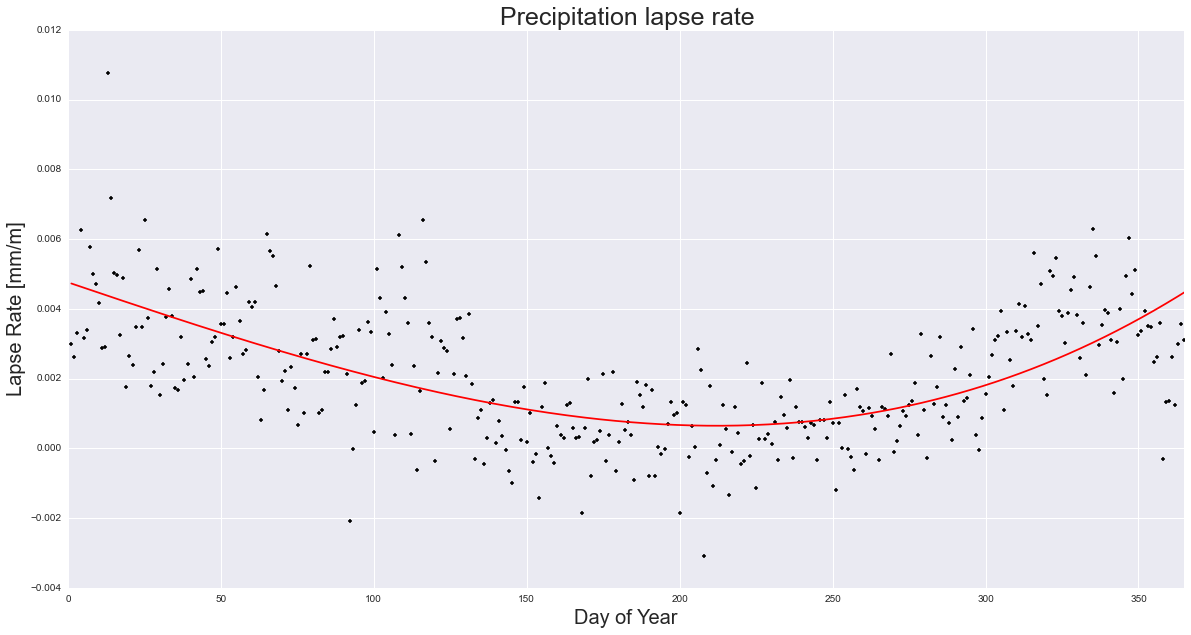

In [106]:
plt.figure(figsize=(20,10))
plt.plot(lap2.index,lap2.plapse,'.k')
plt.plot(lap2.index,lap2.pspline,'-r')
plt.xlim(0,365)
print lap2.pspline.mean()
plt.title('Precipitation lapse rate', fontsize = 25)
plt.xlabel('Day of Year', fontsize = 20)
plt.ylabel('Lapse Rate [mm/m]', fontsize = 20)

-0.00765675457918


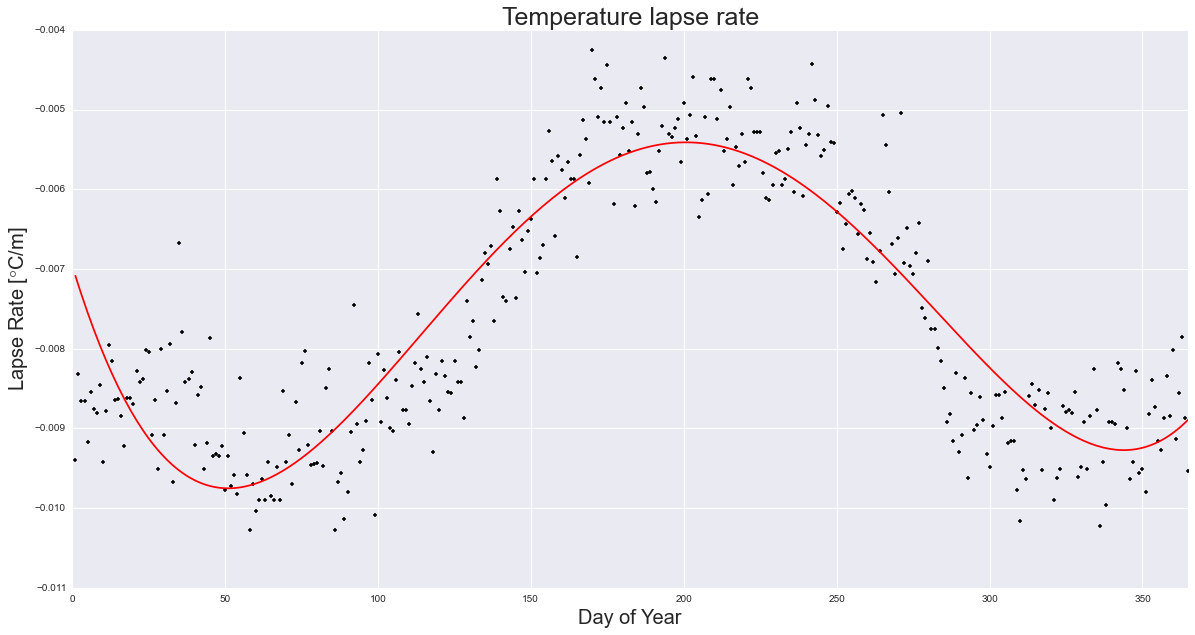

In [105]:
plt.figure(figsize=(20,10))
plt.plot(lap2.index,lap2.tlapse,'.k')
plt.plot(lap2.index,lap2.tspline,'-r')
plt.xlim(0,365)
print lap2.tspline.mean()
plt.title('Temperature lapse rate', fontsize = 25)
plt.xlabel('Day of Year', fontsize = 20)
plt.ylabel('Lapse Rate [$\degree$C/m]', fontsize = 20)